<a href="https://colab.research.google.com/github/andhikayusup/IAT-mobile/blob/master/COVID_Model_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import csv
import shutil
import random
import numpy as np
import tensorflow as tf
from os import getcwd
from shutil import copyfile
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# COVID Model

In [2]:
! pip install -q kaggle

In [3]:
# Upload kaggle API Token
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andhikayusup","key":"19abc61e6460e1fa8ddc35ce80be2685"}'}

In [5]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database
! unzip -q covid19-radiography-database.zip

 98% 731M/745M [00:24<00:00, 25.4MB/s]
100% 745M/745M [00:24<00:00, 32.1MB/s]


In [6]:
try:
    os.mkdir(f'{getcwd()}/dataset/')
    os.mkdir(f'{getcwd()}/dataset/training/')
    os.mkdir(f'{getcwd()}/dataset/testing/')
    os.mkdir(f'{getcwd()}/dataset/training/normal/')
    os.mkdir(f'{getcwd()}/dataset/training/covid/')
    os.mkdir(f'{getcwd()}/dataset/testing/normal/')
    os.mkdir(f'{getcwd()}/dataset/testing/covid/')
    
except OSError:
    pass

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

NORMAL_SOURCE_DIR = f'{getcwd()}/COVID-19_Radiography_Dataset/Normal/'
TRAINING_NORMAL_DIR = f'{getcwd()}/dataset/training/normal/'
TESTING_NORMAL_DIR = f'{getcwd()}/dataset/testing/normal/'
COVID_SOURCE_DIR = f'{getcwd()}/COVID-19_Radiography_Dataset/COVID/'
TRAINING_COVID_DIR = f'{getcwd()}/dataset/training/covid/'
TESTING_COVID_DIR = f'{getcwd()}/dataset/testing/covid/'

split_size = .7
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, split_size)
split_data(COVID_SOURCE_DIR, TRAINING_COVID_DIR, TESTING_COVID_DIR, split_size)

In [24]:
TRAINING_DIR = f'{getcwd()}/dataset/training/'
train_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    color_mode="grayscale",
    batch_size=10,
    class_mode="categorical"
)

VALIDATION_DIR = f'{getcwd()}/dataset/testing/'
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    color_mode="grayscale",
    batch_size=10,
    class_mode="categorical"
)

Found 9665 images belonging to 2 classes.
Found 4143 images belonging to 2 classes.


In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides=1, padding='same', activation="relu", input_shape=(150, 150, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
    tf.keras.layers.Conv2D(128, (3,3), strides=1, padding='same', activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
    tf.keras.layers.Conv2D(256, (3,3), strides=1, padding='same', activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), strides=2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation="softmax")
])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [27]:
history = model.fit(train_generator,
                    epochs=12,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [learning_rate_reduction])

Epoch 1/12
967/967 [==============================] - 666s 687ms/step - loss: 0.6856 - accuracy: 0.7339 - val_loss: 0.5852 - val_accuracy: 0.7381
Epoch 2/12
967/967 [==============================] - 659s 681ms/step - loss: 0.4902 - accuracy: 0.7853 - val_loss: 2.6887 - val_accuracy: 0.2619
Epoch 3/12
967/967 [==============================] - 673s 696ms/step - loss: 0.4552 - accuracy: 0.8077 - val_loss: 1.3734 - val_accuracy: 0.7381

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
967/967 [==============================] - 672s 695ms/step - loss: 0.3190 - accuracy: 0.8770 - val_loss: 1.7062 - val_accuracy: 0.7381
Epoch 5/12
967/967 [==============================] - 669s 692ms/step - loss: 0.2860 - accuracy: 0.8913 - val_loss: 2.7406 - val_accuracy: 0.7381

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/12
967/967 [==============================] - 652s 674ms/step - loss: 0.2286 - accuracy: 0.9136 - va

Text(0.5, 1.0, 'Training and validation loss')

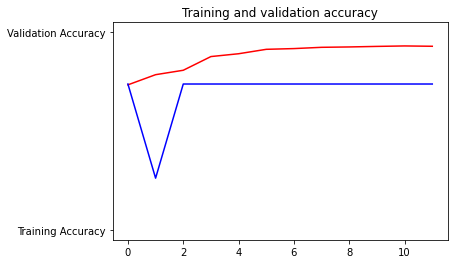

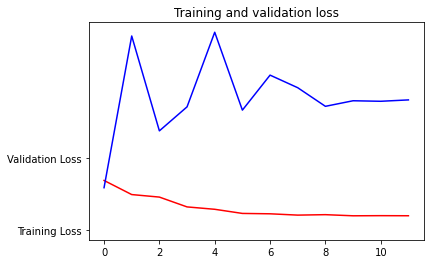

In [29]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [43]:
import pathlib

output_name = f'{getcwd()}/saved_model/covid_model.h5'
model.save(output_name)

In [31]:
!zip -r covid_model.zip /content/saved_model/covid_model

NameError: ignored

In [39]:
import cv2

loaded_model = tf.keras.models.load_model(output_name)

In [42]:
img2 = cv2.imread('/content/dataset/testing/covid/COVID-1000.png', 0)
img2 = cv2.resize(img2,(150,150))
img2 = np.reshape(img2,[1, 150, 150, 1])

loaded_model.predict(img2)


array([[9.9926895e-01, 7.3106994e-04]], dtype=float32)

In [ ]:
! rm -r saved_model

9504368

In [ ]:
!